In [1]:
import numpy as np
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('using device:', device)

using device: cuda


In [2]:
import os
from typing import Tuple


def load_dataset(path: os.PathLike) -> Tuple[torch.Tensor, torch.Tensor]:
    X = np.load(os.path.join(path, 'inputs.npy'))
    T = np.load(os.path.join(path, 'targets.npy'))

    N = X.shape[0]
    X = X.reshape((N, 1, 256, 256)) # reshape to 1-channel for convolutions

    return torch.tensor(X, dtype=torch.float32), \
        torch.tensor(T, dtype=torch.long)

# X_train = torch.tensor(X, device=device, dtype=torch.float32)
# y_train = torch.tensor(T, device=device, dtype=torch.long)
X_train, y_train = load_dataset('model_train/train')

n_classes = int(y_train.max()) + 1
X_train.shape, y_train.shape, n_classes

(torch.Size([28800, 1, 256, 256]), torch.Size([28800]), 237)

In [3]:
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

from model import create_model

model = create_model(n_classes, device)

optim = AdamW(model.parameters(), lr=1e-4)
loss_fn = CrossEntropyLoss()

In [4]:
with torch.no_grad():
    o = model(X_train[:1].to(device))
    loss = loss_fn(o, y_train[:1].to(device))
    print(loss)

tensor(5.4680, device='cuda:0')


In [5]:
epochs     = 30
batch_size = 128

In [6]:
from model import train

t_l, v_l = train(model, epochs, X_train, y_train, optim, loss_fn, device, bs=batch_size)

Starting training.
Number of minibatches for training/test: 197/29
Starting epoch 1 of 30


c:\Users\cupof\repos\audio-project\.venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\cupof\repos\audio-project\.venv\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


	Training took: 1425.55s	with loss: 5.454709
Starting epoch 2 of 30
	Training took: 1452.59s	with loss: 5.454657
Starting epoch 3 of 30
	Training took: 1382.84s	with loss: 5.454658
Starting epoch 4 of 30
	Training took: 1203.53s	with loss: 5.454656
Starting epoch 5 of 30
	Training took: 1177.31s	with loss: 5.454654
Starting epoch 6 of 30
	Training took: 1152.68s	with loss: 5.454656
Starting epoch 7 of 30
	Training took: 1145.46s	with loss: 5.454657
Starting epoch 8 of 30
	Training took: 1158.67s	with loss: 5.454655
Starting epoch 9 of 30
	Training took: 1171.87s	with loss: 5.454655
Starting epoch 10 of 30
	Training took: 1145.59s	with loss: 5.454657
Starting epoch 11 of 30
	Training took: 1113.10s	with loss: 5.454657
Starting epoch 12 of 30
	Training took: 1107.08s	with loss: 5.454658
Starting epoch 13 of 30
	Training took: 1105.22s	with loss: 5.454655
Starting epoch 14 of 30
	Training took: 1086.07s	with loss: 5.454658
Starting epoch 15 of 30
	Training took: 988.71s	with loss: 5.45465

KeyboardInterrupt: 

In [6]:
np.save('train_losses_new.npy', t_l)
np.save('valid_losses_new.npy', v_l)

In [9]:
t_l = []
v_l = []

ckpt_path = 'checkpoints/11-06-2024-11-35-39'

for f in os.listdir(ckpt_path):
    if not f.endswith('.pt'):
        continue
    ckpt = torch.load(os.path.join(ckpt_path, f))
    t_l.append(ckpt['train_loss'])
    v_l.append(ckpt['valid_loss'])

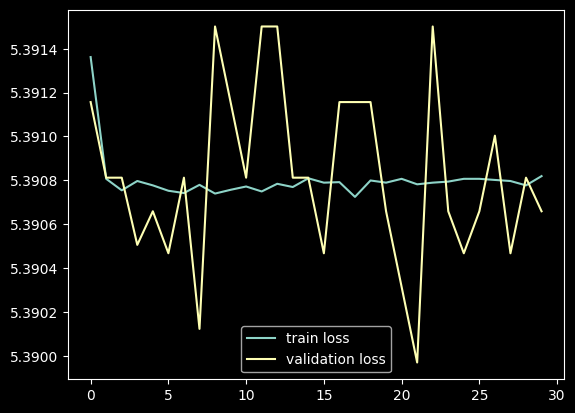

In [7]:
import matplotlib.pyplot as plt

n = len(t_l)

ax = plt.subplot()
ax.plot(np.arange(n), t_l, label='train loss')
ax.plot(np.arange(n), v_l, label='validation loss')
plt.legend()

In [8]:
from model import eval_acc, load_model_checkpoint

accs = [0] * 21
test_accs  = [0] * 21

ckpt_path = 'checkpoints/19-06-2024-13-12-34'

X_test, y_test = load_dataset('model_train/test')

model.eval()
for f in os.listdir(ckpt_path):
    if not f.endswith('.pt'):
        continue
    model_file = os.path.join(ckpt_path, f)
    ckpt = load_model_checkpoint(model_file, model, device=device)
    e = ckpt['epoch']
    # ckpt = torch.load(model_file, map_location='cuda')
    tr_acc = eval_acc(model, X_train, y_train, device, bs=batch_size)
    te_acc = eval_acc(model, X_test, y_test, device, bs=batch_size)
    accs[e] = tr_acc
    test_accs[e] = te_acc

c:\Users\cupof\repos\audio-project\.venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


KeyboardInterrupt: 

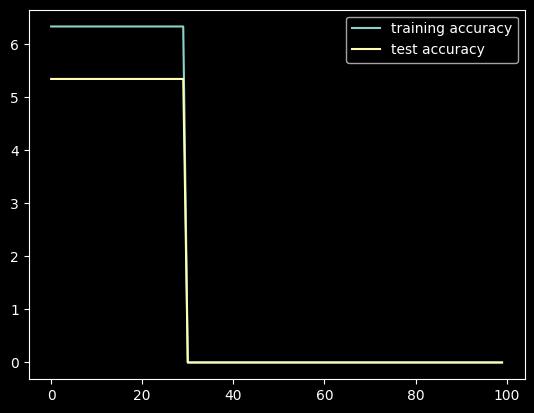

In [9]:
import matplotlib.pyplot as plt

np_accs = np.array(accs) * 100
np_test_accs = np.array(test_accs) * 100

ax = plt.subplot()
ax.plot(np.arange(len(accs)), np_accs, label='training accuracy')
ax.plot(np.arange(len(accs)), np_test_accs, label='test accuracy')
plt.legend()